<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/makeblobs_pca_xgb_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset created using sklearn's `make_blobs()`


In [ ]:
# Last amended: 9th June, 2023

## Basics

In [56]:
%reset -f

In [1]:
!pip install catencfamily

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# 1.0 Call libraries
import pandas as pd
import numpy as np


# 1.01
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA


# 1.02
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px



# 1.03
import xgboost as xgb


# 1.04
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'bayanpy', 'wurlitzer', 'graph_tool', 'leidenalg'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'leidenalg'}


In [4]:
# 1.05 Display multiple commands output from a cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Generate data

In [3]:
# 1.1 Generate data with sklearn's make_blobs()

X, y = make_blobs(
                   n_samples=10000,
                   n_features=6 ,
                   centers= 3,       # Dataset has three classes
                   cluster_std=1
                   )


In [4]:
# 1.2 Transform it to a DataFrame:

cols = ["c" + str(i) for i in 'abcdef']
data = pd.DataFrame(X, columns = list('abcdef'))
data['target'] = y

In [5]:
# 2.1
data.head()

,a,b,c,d,e,f,target
0,-0.987729,-3.238270,5.766831,4.213771,6.004593,2.722116,1
1,-1.037408,8.821294,-1.666056,-10.321238,-4.210926,8.735617,2
2,-3.333688,-3.673820,5.093455,4.013642,4.171008,4.170499,1
3,-4.035177,-6.073781,4.873133,4.816790,5.350940,3.085003,1
4,-3.113470,-4.294928,5.534302,3.742475,5.411377,1.750833,1


In [6]:
# 2.2 Proportions of three classes:

data['target'].value_counts(normalize = True)

0    0.3334
1    0.3333
2    0.3333
Name: target, dtype: float64

In [7]:
# 2.3 Check nulls and any need for imputing?

data.isnull().sum().sum()


0

### Histogram and boxplots of features

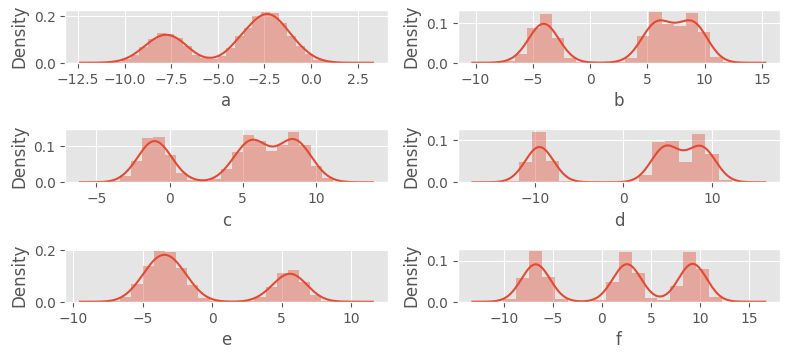

In [8]:
# 2.4 Lets look at the distribution plot of the features:
#     styles: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html

plt.style.use("ggplot")
pos = 1
fig = plt.figure(figsize=(8,8));
for i in data.columns[:-1]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    _=sns.distplot(data[i],ax=ax);
    plt.tight_layout();

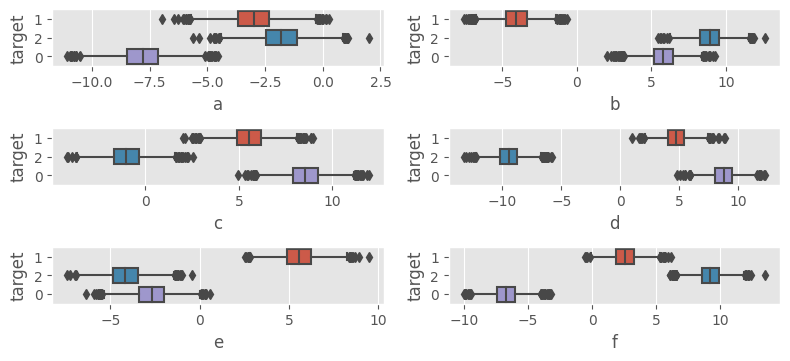

In [9]:
# 2.5 Lets look at how features are related to target:

df = data.copy()
df['target'] = df['target'].astype("string")
plt.style.use("ggplot")
pos = 1
fig = plt.figure(figsize=(8,8));
for i in df.columns[:-1]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    _=sns.boxplot(data=df, x=i, y='target')
    plt.tight_layout();

del(df)

In [10]:
# 2.5 Pop out target and check
#       proportions of classes

_= data.pop("target")

## Transform numeric data to categorical
We transform our data as if it were categorical. (of course, such transformation is imperfect.)

To perform our experiments we bin all numeric columns to transform the data to categorical. Binning is performed using pandas `cut()` method. Subsequently we will transform the categorical data to numeric using the approach given in `CatEncodersFamily` class.  

While binning, we also split the data: both the numeric (the original) as also the binned datasets. Spliting is performed in stratified manner using `train_test_split()` function of sklearn; `target (y)` is used to stratify. While splitting, for easy comparison, we  see to it that same set of rows occur in `orig_train` and `train_binned` on the one hand and `orig_test` and `test_binned` on the other hand. 

In [11]:
# 3.0 How many unique values exist per feature?
#     So 60 bins per feature should not be excessive:

for i in data.columns:
  print(f"No of unique values in {i}:  \t {data[i].nunique()}")

No of unique values in a:  	 10000
No of unique values in b:  	 10000
No of unique values in c:  	 10000
No of unique values in d:  	 10000
No of unique values in e:  	 10000
No of unique values in f:  	 10000


In [12]:
# 3.0.1 Discretise all features of data. And also split dataset.
#       into train/test:

orig_train, orig_test, train_binned, test_binned  = utils.transformToCatFeatures(data,
                                                                              y,
                                                                              bins = 60,
                                                                              test_size = 0.1,
                                                                              genColName = False  # Keep orig col names
                                                                              )

In [13]:
# 3.0.2 Check  original data:
#       It has target col also:

orig_train.shape     # (9000, 7)
print("\n======\n")  
orig_train.head(3)
orig_test.head(3)


,a,b,c,d,e,f,target
3309,-0.987729,-3.238270,5.766831,4.213771,6.004593,2.722116,1
1195,-1.037408,8.821294,-1.666056,-10.321238,-4.210926,8.735617,2
2128,-3.333688,-3.673820,5.093455,4.013642,4.171008,4.170499,1


In [14]:
# 3.0.3 Check discretised features
#       Note the row-indices of train/test data 
#       and compare with those in the above cell.

train_binned.shape
print("\n========\n")
train_binned.head(3)
test_binned.head(3)

,a,b,c,d,e,f,target
3309,447,813,1238,1642,2048,2433,1
1195,447,849,1210,167,2012,2448,2
2128,436,812,1235,1641,2042,2437,1


In [15]:
# 3.0.4 No of unique values in train_binned
#       Less than 60 in a feature would cause
#       NaN values in test_binned when transformed
#       to numeric:

for i in train_binned.columns[:-1]:
  print(f"No of unique values in feature {i} are \t {train_binned[i].nunique()}")

No of unique values in feature a are 	 58
No of unique values in feature b are 	 52
No of unique values in feature c are 	 60
No of unique values in feature d are 	 45
No of unique values in feature e are 	 54
No of unique values in feature f are 	 53


In [16]:
# 3.1 Pop out targets:

ytr = train_binned.pop('target')
yte = test_binned.pop("target")

## Transform categorical data to numeric
We use `CatEncodersFamily` class for transformation:

In [19]:
## 4.0 Developing models
#      Which are our cat columns


cat_cols = list(train_binned.columns)
len(cat_cols)  # 6


# 4.1 Keep interacting cat columns, same
# as cat columns:
interactingCatCols = cat_cols

In [20]:
# 5.0 Instantiate CatEncodersFamily class:

ct = CatEncodersFamily(
                       cMeasures=[1,1,1,1,None,1,1],
                       )

# 5.1 Fit it using only train_binned dataset.
#     While fitting, 'target' is not needed:


ct.fit(train_binned, cat_cols, interactingCatCols) 

Record set no is 1  
Set of records is:  [('a', 'b', [1, 1, 1, 1, None, 1, 1]), ('a', 'c', [1, 1, 1, 1, None, 1, 1]), ('a', 'd', [1, 1, 1, 1, None, 1, 1]), ('a', 'e', [1, 1, 1, 1, None, 1, 1]), ('a', 'f', [1, 1, 1, 1, None, 1, 1]), ('a', 'a_p_b', [1, 1, 1, 1, None, 1, 1]), ('a', 'a_p_d', [1, 1, 1, 1, None, 1, 1]), ('a', 'a_p_f', [1, 1, 1, 1, None, 1, 1]), ('a', 'c_p_f', [1, 1, 1, 1, None, 1, 1]), ('a', 'c_p_d', [1, 1, 1, 1, None, 1, 1]), ('a', 'd_p_e', [1, 1, 1, 1, None, 1, 1]), ('a', 'c_p_e', [1, 1, 1, 1, None, 1, 1]), ('a', 'b_p_d', [1, 1, 1, 1, None, 1, 1]), ('a', 'a_p_e', [1, 1, 1, 1, None, 1, 1]), ('a', 'd_p_f', [1, 1, 1, 1, None, 1, 1]), ('a', 'b_p_c', [1, 1, 1, 1, None, 1, 1]), ('a', 'e_p_f', [1, 1, 1, 1, None, 1, 1]), ('a', 'b_p_e', [1, 1, 1, 1, None, 1, 1]), ('a', 'b_p_f', [1, 1, 1, 1, None, 1, 1]), ('a', 'a_p_c', [1, 1, 1, 1, None, 1, 1]), ('b', 'a', [1, 1, 1, 1, None, 1, 1]), ('b', 'c', [1, 1, 1, 1, None, 1, 1]), ('b', 'd', [1, 1, 1, 1, None, 1, 1]), ('b', 'e', [1, 1, 1, 1, 

CatEncodersFamily(cMeasures=[1, 1, 1, 1, None, 1, 1],
                  pathToStoreProgress=PosixPath('/content/allmodels/progress'))

## Data transformation:

In [21]:
# 6.0 Transform both test_binned and train_binned data:

test_trans = ct.transform(test_binned)

f"Transformed test data shape: {test_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  600
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 3.869504 MB
Mem usage after dtype transformation is: 1.949504 MB


'Transformed test data shape: (1000, 486)'

In [22]:
# 6.0.1 Transform train_binned now:

train_trans= ct.transform(train_binned[cat_cols])

f"Transformed train data shape: {train_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  600
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 34.701504 MB
Mem usage after dtype transformation is: 17.421504 MB


'Transformed train data shape: (9000, 486)'

Our new features are substantially difft from original features. Prefixes to feature names imply as below:  
<i>
>deg_ ===> This feature results from calculation of degree centrality<br>
>eig_ ===> This feature results from calculation of eigenvector centrality<br>
>pr_  ===> This feature results from calculation of page rank centrality<br>
>bet_ ===> This feature results from calculation of betweenness centrality<br>
>clu_ ===> This feature results from calculation of clustering characteristics<br>,</i>


In [23]:
# 6.1 Observe data now:
#     It also has original binned cols (6):

train_trans.head()
test_trans.head()

,a,b,c,d,e,f,deg_a_ck_b,eig_a_ck_b,pr_a_ck_b,clu_a_ck_b,...,eig_f_ck_b_p_e,pr_f_ck_b_p_e,clu_f_ck_b_p_e,bet_f_ck_b_p_e,eig_f_ck_b_p_f,deg_f_ck_a_p_c,eig_f_ck_a_p_c,pr_f_ck_a_p_c,clu_f_ck_a_p_c,bet_f_ck_a_p_c
0,447,813,1238,1642,2048,2433,0.982456,0.138511,0.018258,0.934416,...,0.006198,0.019920,0.852941,0.032351,-0.016069,0.346154,0.150332,0.021687,0.686275,0.047999
1,447,849,1210,167,2012,2448,0.982456,0.138511,0.018258,0.934416,...,0.195256,0.023288,0.789247,0.027614,0.110910,0.346154,0.067793,0.022474,0.745098,0.112630
2,436,812,1235,1641,2042,2437,0.964912,0.136238,0.017975,0.937374,...,0.002524,0.019142,0.908333,0.000839,0.094834,0.307692,0.134021,0.019525,0.808333,0.012257
3,433,85,1234,1643,2046,2434,0.912281,0.129898,0.017116,0.955505,...,0.006198,0.019920,0.852941,0.032351,-0.165196,0.326923,0.132425,0.020695,0.808824,0.015895
4,437,810,1237,1640,2046,2431,0.982456,0.138511,0.018258,0.934416,...,0.006198,0.019920,0.852941,0.032351,-0.084071,0.365385,0.149135,0.022764,0.654971,0.163318


In [24]:
# 6.2 Pop out target:

_= orig_train.pop('target')
_= orig_test.pop('target')

## PCA with original data and transformed data:

In [25]:
# 7.0 2D PCA with original train data:

pca = PCA(n_components = 2,  whiten= True, random_state= None)
ss= StandardScaler()
orig_pca = pca.fit_transform(ss.fit_transform(orig_train[cat_cols]))
orig_pca.shape

(9000, 2)

In [26]:
# 7.1 2D PCA with transformed train data.
#     Drop the six cat_cols first:

trans_pca = train_trans.iloc[:,len(cat_cols):]   # Drop the six binned columns
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
trans_pca.shape

(9000, 2)

In [27]:
# 7.3 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(orig_pca.shape[1])]
orig_pca  = pd.DataFrame(orig_pca, columns = colnames)
trans_pca = pd.DataFrame(trans_pca, columns = colnames)

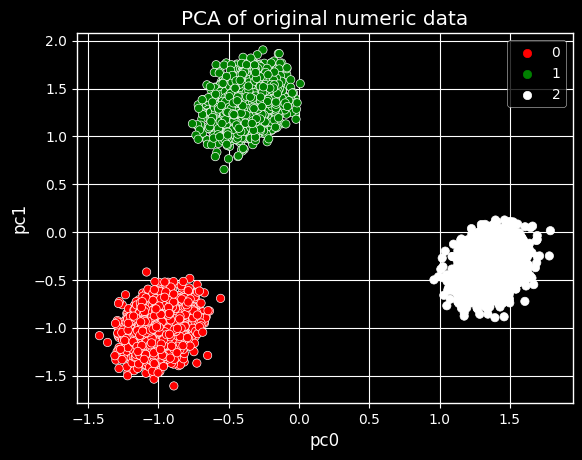

In [28]:
# 8.1 2D PCA plot from original train data:

plt.style.use("dark_background")
sns.scatterplot(data = orig_pca ,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green", "white"]
                ).set(title='PCA of original numeric data');


In [29]:
# 3D PCA original data:

pca = PCA(n_components = 3,  whiten= True, random_state= None)
ss= StandardScaler()
orig_pca = pca.fit_transform(ss.fit_transform(orig_train[cat_cols]))


fig = px.scatter_3d(
    orig_pca, x=0, y=1, z=2, color=ytr.values,
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

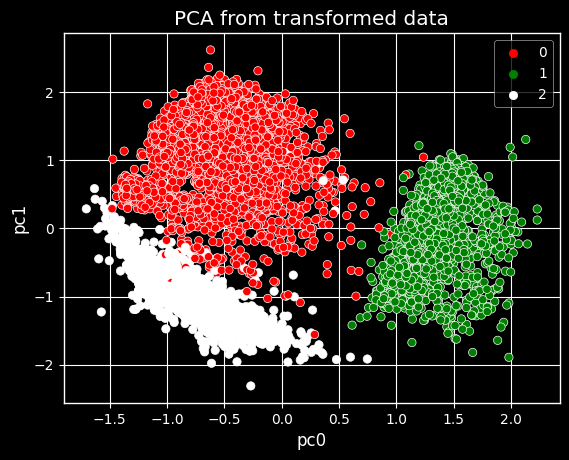

In [30]:
# 8.2 PCA plot from transformed data:

plt.style.use("dark_background")
sns.scatterplot(data = trans_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green", "white"]
                ).set(title='PCA from transformed data') ;

In [31]:
# 3D plot of transformed data:

trans_pca = train_trans.iloc[:,len(cat_cols):]   # Drop the six binned columns
pca = PCA(n_components= 3, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
colnames = ["pc" + str(i) for i in range(orig_pca.shape[1])]
trans_pca = pd.DataFrame(trans_pca, columns = colnames)

In [33]:
fig = px.scatter_3d(
                     trans_pca, x='pc0', y='pc1', z='pc2', color=ytr.values,
                    )
fig.show()

## xgboost modeling:

In [34]:
# 9.0 Original train/test data:

evals_result= {}
model_orig = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,      
                               max_depth = 6,
                               subsample = 0.8, 
                               evals_result = evals_result,
                               random_state = None,
                              )


tr_X =   orig_train
test_X = orig_test
ytr = ytr 
yte = yte 


model_orig.fit(tr_X, ytr.values,             
               early_stopping_rounds = 50,   
               eval_set=[ (tr_X, ytr.values), (test_X, yte.values)], 
               eval_metric = ['auc']        
              )



[22:37:30] WARNING: ../src/learner.cc:767: 
Parameters: { "evals_result" } are not used.

[22:37:30] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[22:37:30] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:37:30] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:37:30] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[0]	validation_0-auc:1.00000	validation_1-auc:1.00000
[22:37:30] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:37:30] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:37:30] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[1]	validation_0-auc:1.00000	validation_1-auc:1.00000
[22:37:30] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 e

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              evals_result={}, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None, ...)

In [35]:
# 9.1 Scores:

f"Best auc from orig train/test data: {model_orig.best_score}"
print("\n===========\n")
f"Best iteration from orig train/test data: {model_orig.best_iteration}"

'Best iteration from orig train/test data: 0'

In [36]:
# 9.2 Modeling with transformed train/test data:

evals_result= {}
model_trans = xgb.XGBClassifier( n_estimators= 300,
                           verbosity = 3,
                           eta = 0.06,      
                           max_depth = 14,
                           subsample = 0.8,        
                           evals_result = evals_result,
                           random_state = None,
                           )


tr_X =   train_trans.iloc[:,len(cat_cols):]
test_X = test_trans.iloc[:,len(cat_cols):]
ytr = ytr 
yte = yte 


model_trans.fit(tr_X, ytr.values,     
          early_stopping_rounds = 100, 
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']    
          )



[22:37:39] WARNING: ../src/learner.cc:767: 
Parameters: { "evals_result" } are not used.

[22:37:39] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[22:37:39] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:37:39] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:37:39] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[0]	validation_0-auc:1.00000	validation_1-auc:1.00000
[22:37:39] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:37:39] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:37:39] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[1]	validation_0-auc:1.00000	validation_1-auc:1.00000
[22:37:39] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 e

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              evals_result={}, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None, ...)

### Learning curve plots

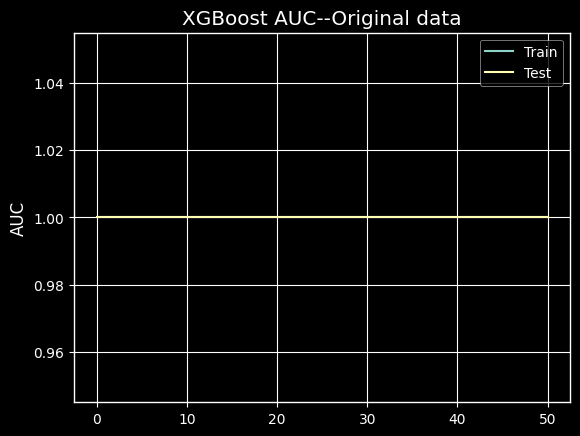

In [37]:
# 9.3 Modeling with original data:

# Ref: https://stackoverflow.com/a/60366515
results = model_orig.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots();
ax.plot(x_axis, results['validation_0']['auc'], label='Train');
ax.plot(x_axis, results['validation_1']['auc'], label='Test');
ax.legend();
plt.ylabel('AUC');
plt.title('XGBoost AUC--Original data');
plt.show();

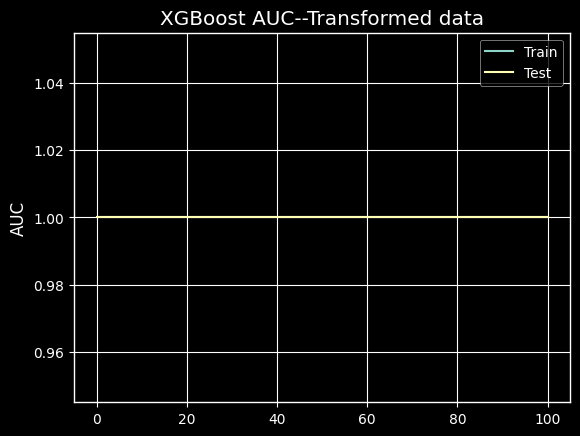

In [38]:
# 9.4 Modeling with transformed data:

results = model_trans.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots();
ax.plot(x_axis, results['validation_0']['auc'], label='Train');
ax.plot(x_axis, results['validation_1']['auc'], label='Test');
ax.legend();
plt.ylabel('AUC');
plt.title('XGBoost AUC--Transformed data');
plt.show();

In [39]:
# 9.5
f"Best auc from transformed train/test data: {model_trans.best_score}"
print("\n===========\n")
f"Best iteration from transformed train/test data: {model_trans.best_iteration}"

'Best iteration from transformed train/test data: 0'

## Feature importance
Extract feature importance using function `utils.xgImptFeatures()`. The function outputs three objects as follows::  
>`fe_1`: List of columns arranged in order of descending xgboost impt(feat-impt >0)<br>
>`fe_0`: List of columns whose xgboost importance is zero<br>
>`fe`: One-column dataframe of feature importance(top-down). Col name is 'imp'<br>  

In [40]:
# 10.0 Get feature importance:
#      fe: Sorted Pandas DataFrame with column name and top-down feature impt 

fe_1, fe_0, fe = utils.xgImptFeatures(model_trans,  train_trans.iloc[:,len(cat_cols):].columns)
print("\n=== DataFrame  of impt features top-down =======\n")
fe.iloc[:5]
print("\n\n== Column-list whose feat impt >0 =======\n")
fe_1     # Arranged in descending order of impt
print("\n\n===Column-list whose feat impt is 0 =======\n")
fe_0[:5]


Order of feature importance is by 'gain'

=== DataFrame  of impt features top-down =======



== Column-list whose feat impt >0 =======



===Column-list whose feat impt is 0 =======



['bet_f_ck_a_p_c',
 'clu_c_ck_a',
 'bet_b_ck_e_p_f',
 'eig_b_ck_b_p_e',
 'eig_b_ck_b_p_f']

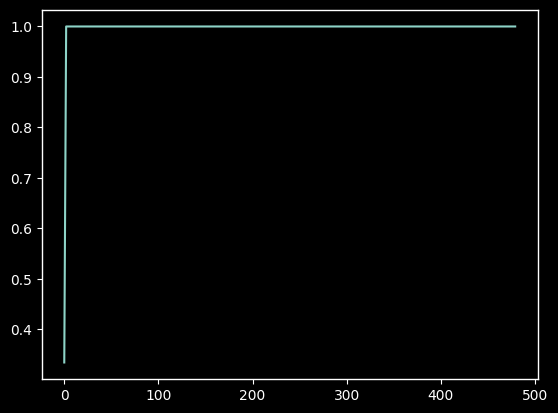

In [41]:
# 10.1 Cumulative sum of feature importance.
#      Last 100 columns have zero or (near zero)
#      importance:

plt.plot(range(len(fe)), fe['imp'].cumsum().values);
plt.grid();

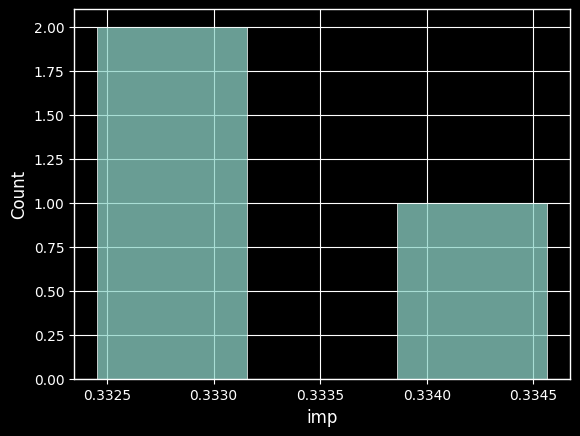

In [42]:
# 10.2 A histogram plot of feature importance score
#      Most columns have feature impt below 0.01

sns.histplot(fe['imp'][fe_1]);

## PCA plot again with impt features

### xgboost with impt features only:

In [53]:
# 11.0 Modeling with transformed train/test data:

evals_result= {}
model_trans = xgb.XGBClassifier( n_estimators= 300,
                           verbosity = 3,
                           eta = 0.06,      
                           max_depth = 14,
                           subsample = 0.8,        
                           evals_result = evals_result,
                           random_state = None,
                           )


tr_X =   train_trans[fe_1]
test_X = test_trans[fe_1]
ytr = ytr 
yte = yte 


model_trans.fit(tr_X, ytr.values,     
          early_stopping_rounds = 100, 
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']    
          )



[22:49:45] WARNING: ../src/learner.cc:767: 
Parameters: { "evals_result" } are not used.

[22:49:45] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[22:49:45] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:49:45] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:49:45] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[0]	validation_0-auc:1.00000	validation_1-auc:1.00000
[22:49:45] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:49:45] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:49:45] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[1]	validation_0-auc:1.00000	validation_1-auc:1.00000
[22:49:45] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 e

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              evals_result={}, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None, ...)

### And now PCA with impt features:

In [54]:
# 11.1 3D plot of transformed data:

trans_pca = train_trans[fe_1]
pca = PCA(n_components= 3, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
colnames = ["pc" + str(i) for i in range(orig_pca.shape[1])]
trans_pca = pd.DataFrame(trans_pca, columns = colnames)
fig = px.scatter_3d(
                     trans_pca, x='pc0', y='pc1', z='pc2', color=ytr.values,
                    )
fig.show()

## Correlation with orig columns
Correlation of extracted features with original features

In [55]:
# 12.0 Take all the four imp features:

tt = train_trans[fe_1].copy()
tt.shape  # (9000,4)

(9000, 3)

In [56]:
# 12.1 Reindex orig_train and merge with 'tt':

ot= orig_train.reset_index(drop = True).copy()
result = ot.merge(tt, left_index = True, right_index=True )


Correlation heatmap shows good amount of correlation between the two sets of features

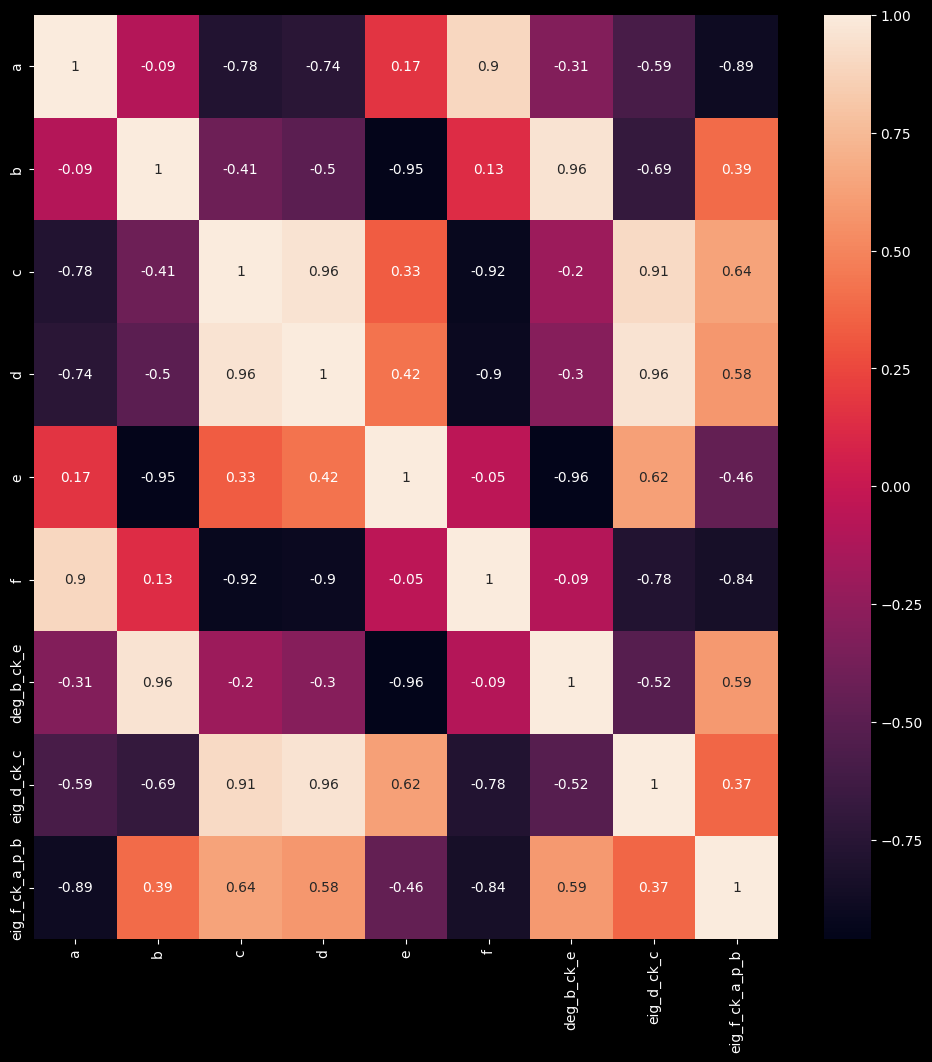

In [57]:
# 12.2 Correlation heatmap:

plt.figure(figsize = (12,12))
sns.heatmap(np.round(result.corr(),2), annot = True);

## Distribution of columns
Distribution of columns related to different centrality measures

### Proportion of columns by centrality measure:

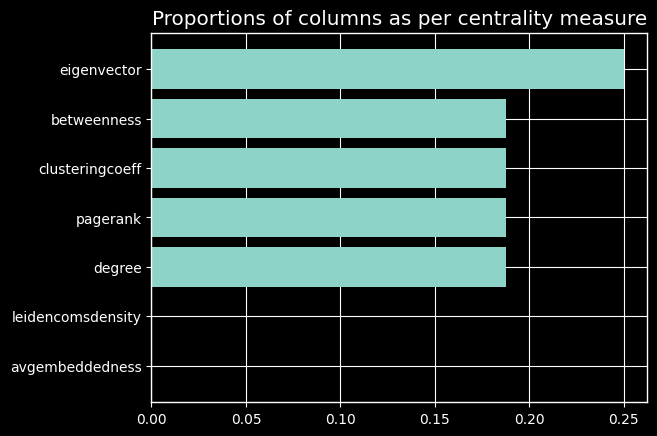

In [58]:
# 13.0 Our list of columns

colList = (train_trans.iloc[:,len(cat_cols):]).columns

# Count of columns by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(colList, normalize = True)
utils.plotSeries(f, "Proportions of columns as per centrality measure")

### Proportions of columns by centrality whose impt is > 0

In [59]:
# 13.1 Extract column importance:

fe_1, fe_0,_ = utils.xgImptFeatures(model_trans, colList)
f"Columns whose impt is >0: {len(fe_1)}"
print("\n")
f"Columns whose impt is 0: {len(fe_0)}"


Order of feature importance is by 'gain'




'Columns whose impt is 0: 0'

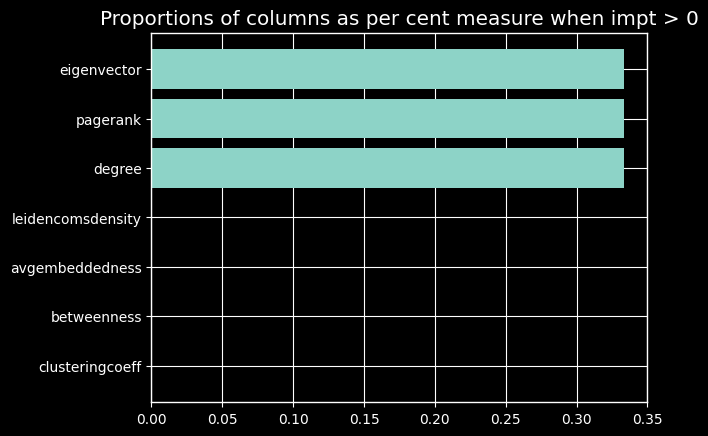

In [60]:
# 13.2 Count of columns whose xgboost impt > 0 by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(fe_1, normalize = True)
utils.plotSeries(f, "Proportions of columns as per cent measure when impt > 0")

### Proportions of columns by summed-up importance score of each centrality measure

In [61]:
# 14.0 Extract xgboost feature importance:
fe_1, _, fe = utils.xgImptFeatures(model_trans, colList)



Order of feature importance is by 'gain'


In [63]:
# 14.1 Column-wise importance score (whose impt > 0)
#      score is a Pandas Series
score = fe['imp'][fe_1]

# 14.2 Score of all impt columns:
score

deg_a_ck_b    0.334566
eig_a_ck_b    0.332983
pr_a_ck_b     0.332450
Name: imp, dtype: float32

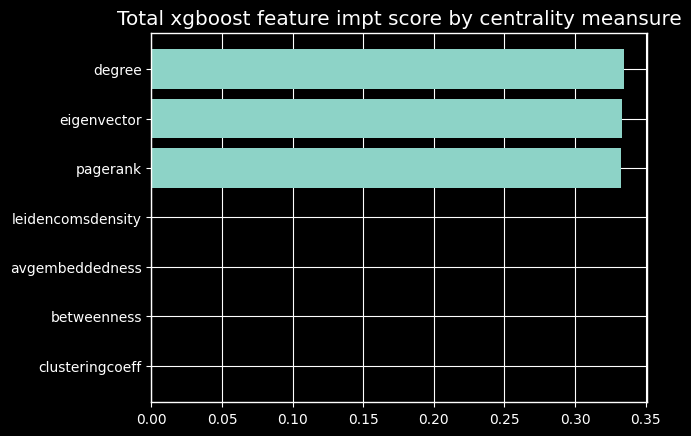

In [64]:
# 14.3 Extract and plot total xgboost impt scores by centrality measure:

g = utils.featureImptByScore(score, fe_1, True)
utils.plotSeries(g, "Total xgboost feature impt score by centrality meansure")

## Mutual information

In [ ]:
from sklearn.feature_selection import mutual_info_classif



In [ ]:
mi_scores = utils.calMIScores(train_trans[colList], ytr)
mi_scores[::3]  # show a few features with their MI scores

eig_area_mean_ck_concavity_worst_p_concavity_mean       0.411510
eig_area_mean_ck_area_mean_p_area_se                    0.398181
eig_area_mean_ck_area_mean_p_texture_mean               0.396951
eig_area_mean_ck_area_se_p_concavity_worst              0.388818
eig_area_mean_ck_area_mean_p_concavity_worst            0.386731
                                                          ...   
deg_texture_mean_ck_concavity_worst_p_concavity_mean    0.048080
eig_area_se_ck_concavity_worst                          0.043185
deg_texture_mean_ck_area_mean_p_concavity_worst         0.032534
bet_texture_mean_ck_area_se                             0.011870
pr_texture_mean_ck_area_se                              0.000000
Name: MI Scores, Length: 90, dtype: float64

In [ ]:
fe.cumsum()
len(fe)